In [105]:
import statistics
import timeit
import itertools
import numpy as np
import torch
import torch.nn as nn
import optuna
import sklearn.metrics as skm
import torch
import importlib
import fastai
import tsai
import torch.nn.functional as F
import copy
import shap
importlib.reload(fastai)
importlib.reload(tsai)

from collections import Counter
from tsai.all import *
from tsai.data.validation import combine_split_data, get_splits
from tsai.models.InceptionTimePlus import InceptionTimePlus
from tsai.tslearner import TSClassifier
from optuna.samplers import TPESampler
from optuna.integration import FastAIPruningCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torch.utils.data import WeightedRandomSampler
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback, ReduceLROnPlateau
from fastai.data.transforms import Categorize
from fastai.losses import BCEWithLogitsLossFlat, FocalLoss, FocalLossFlat
from fastai.metrics import accuracy, BrierScore, F1Score, RocAucBinary


import Data_load_neat as Data_load
import MLmodel_opt_learner_neat as MLmodel_opt_learner

In [106]:
np.set_printoptions(precision=4,suppress = True)

In [107]:
# load in arguments from command line
name = "SimpleData"
model_name="ResNet"
randnum_split=3
epochs=8
device = 1
filepath="/home/DIDE/smishra/Simulations/"
folds=5

In [115]:

X_raw = np.load("".join([filepath,"input_data_simple/",name, "_X.npy"])).astype(np.float32)


Y_raw = np.squeeze(np.load("".join([filepath,"input_data_simple/",name, "_YH.npy"])))
Y = Y_raw[:, np.shape(Y_raw)[1] - 1]


In [116]:
Y.shape

(100000,)

In [117]:
#X_raw, y_raw = Data_load.load_data(name=name,filepath=filepath)

## Function to obtain the train/test split
X_trainvalid, Y_trainvalid, X_test, Y_test, splits = Data_load.split_data(X=X_raw,Y=Y,randnum=randnum_split)

## Now scale all the data for ease (can fix this later)
#X_scaled=Data_load.prep_data(X_raw,splits)

#X_trainvalid_s, X_test_s=X_scaled[splits[0]], X_scaled[splits[1]]


Random state set:3, cuda used: True
Counter({0: 50012, 1: 49988}) Counter({0: 40010, 1: 39990}) Counter({0: 10002, 1: 9998})


In [118]:
# Give the architecture for each model
if model_name=="LSTMFCN":
    arch=LSTM_FCNPlus

if model_name=="TCN":
    arch=TCN

if model_name=="XCM":
    arch=XCMPlus

if model_name=="ResCNN":
    arch=ResCNN

if model_name=="ResNet":
    arch=ResNetPlus

if model_name=="InceptionTime":
    arch=InceptionTimePlus

if model_name=="MLSTMFCN":
    arch=MLSTM_FCNPlus


## Set seed
Data_load.random_seed(randnum_split)

## split out the test set
splits_9010 = get_splits(
        Y_trainvalid,
        valid_size=0.1,
        stratify=True,
        shuffle=True,
        test_size=0,
        show_plot=False,
        random_state=randnum_split
        )
Xtrainvalid90=X_trainvalid[splits_9010[0]]
Ytrainvalid90=Y_trainvalid[splits_9010[0]]
Xtrainvalid10=X_trainvalid[splits_9010[1]]
Ytrainvalid10=Y_trainvalid[splits_9010[1]]

randnum=1

Random state set:3, cuda used: True


In [119]:
def test_results(f_model,X_test,Y_test):

    valid_dl=f_model.dls.valid

    # obtain probability scores, predicted values and targets
    test_ds=valid_dl.dataset.add_test(X_test,Y_test)
    test_dl=valid_dl.new(test_ds)
    test_probas, test_targets,test_preds=f_model.get_preds(dl=test_dl,with_decoded=True,save_preds=None,save_targs=None)

    # get the min, max and median of probability scores for each class
    where1s=np.where(Y_test==1)
    where0s=np.where(Y_test==0)
    test_probasout=test_probas.numpy()
    test_probasout=test_probasout[:,1]
    print("Y equal 0:")
    print([min(test_probasout[where0s]),statistics.mean(test_probasout[where0s]),max(test_probasout[where0s])])
    print("Y equal 1:")
    print([min(test_probasout[where1s]),statistics.mean(test_probasout[where1s]),max(test_probasout[where1s])])

    ## get the various metrics for model fit
    acc=skm.accuracy_score(test_targets,test_preds)
    prec=skm.precision_score(test_targets,test_preds)
    rec=skm.recall_score(test_targets,test_preds)
    fone=skm.f1_score(test_targets,test_preds)
    auc=skm.roc_auc_score(test_targets,test_preds)
    prc=skm.average_precision_score(test_targets,test_preds)
    print(f"accuracy: {acc:.4f}")
    print(f"precision: {prec:.4f}")
    print(f"recall: {rec:.4f}")
    print(f"f1: {fone:.4f}")
    print(f"auc: {auc:.4f}")
    print(f"prc: {prc:.4f}")

    return acc, prec, rec, fone, auc, prc

In [120]:

# loop for fitting model with generic/pre-specified hyperparameters
lr_max=1e-3
batch_size=128
alpha=0.5
gamma=2

colnames=["data","model","seed","epochs", "accuracy", "precision", "recall", "f1", "auc","prc", "time","lr_max","batch_size","alpha","gamma"]
output = pd.DataFrame(columns=colnames)

# Fitting the model on train/test with pre-selected hyperparameters
# define the metrics for model fitting output
metrics=[accuracy,F1Score(),RocAucBinary(),BrierScore()]
weights=torch.tensor([alpha,1-alpha], dtype=torch.float).to(device)

ESPatience=2

# prep the data for the model
tfms=[None,[Categorize()]]
dsets = TSDatasets(X_trainvalid, Y_trainvalid, tfms=tfms, splits=splits_9010,inplace=True)

dls=TSDataLoaders.from_dsets(
    dsets.train,
    dsets.valid,
    bs=batch_size,
    num_workers=0,
    device=device
    )

for i in range(10):
    x,y = dls.one_batch()
    print(sum(y)/len(y))

print(dls.c)
print(dls.len)
print(dls.vars)


TensorCategory(0.4922, device='cuda:1')
TensorCategory(0.4766, device='cuda:1')
TensorCategory(0.5469, device='cuda:1')
TensorCategory(0.4766, device='cuda:1')
TensorCategory(0.4297, device='cuda:1')
TensorCategory(0.4922, device='cuda:1')
TensorCategory(0.5391, device='cuda:1')
TensorCategory(0.4609, device='cuda:1')
TensorCategory(0.5547, device='cuda:1')
TensorCategory(0.6016, device='cuda:1')
2
16
2


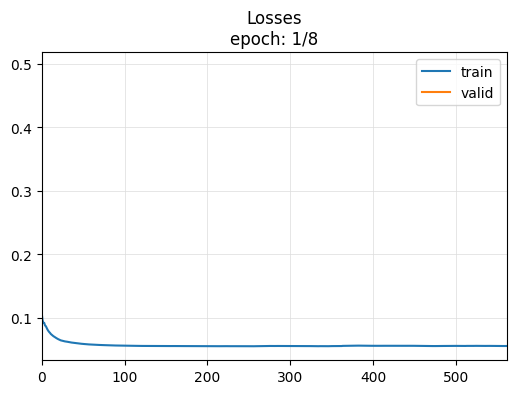

Epoch 4: reducing lr to 5.004708820169149e-05


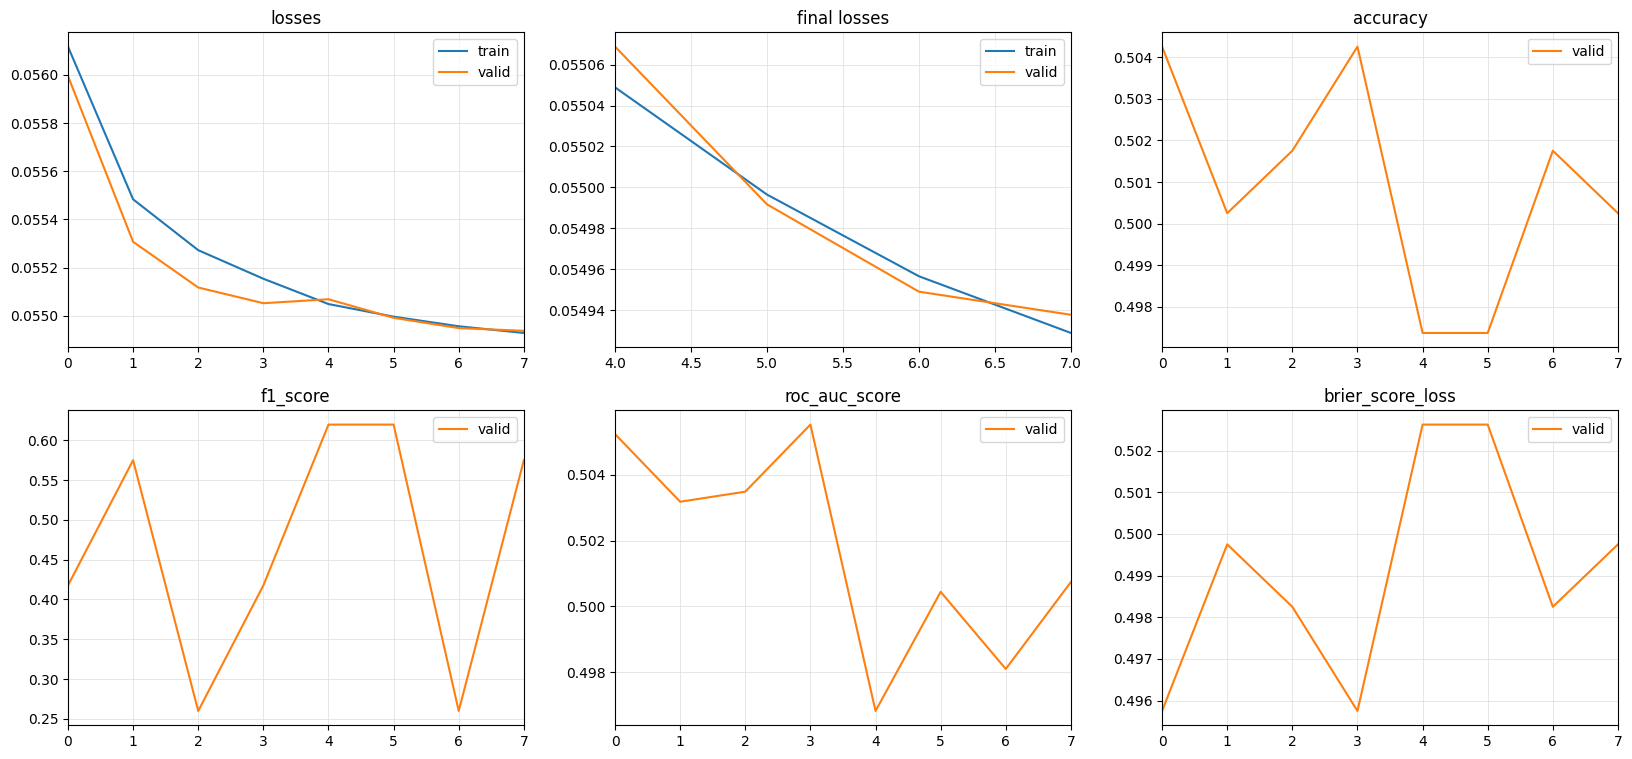

Y equal 0:
[0.49964774, 0.5009146, 0.5018445]
Y equal 1:
[0.49964774, 0.50091684, 0.5018445]
accuracy: 0.5009
precision: 0.5006
recall: 0.6792
f1: 0.5764
auc: 0.5009
prc: 0.5003
Y 0, predicted 0 (true negatives)        3226.000000
Y 0, predicted 1 (false positives)       6776.000000
Y 1, predicted 0 (false negatives)       3207.000000
Y 1, predicted 1 (true positives)        6791.000000


(0.50085,
 0.5005528119702218,
 0.6792358471694339,
 0.5763632505834925,
 0.5008856700354267,
 0.500343413291636,
 3226,
 6776,
 3207,
 6791)

In [121]:
Data_load.random_seed2(randnum,dls=dls)

model = arch(dls.vars, dls.c,dls.len)

model.to(device)

learn = Learner(
    dls, 
    model, 
    metrics=metrics,
    loss_func=FocalLossFlat(gamma=torch.tensor(gamma).to(device),weight=weights),
    cbs=[EarlyStoppingCallback(patience=ESPatience),ReduceLROnPlateau(),ShowGraph()]
    )

learn.fit_one_cycle(epochs, lr_max)

MLmodel_opt_learner.test_results(learn,X_test,Y_test)


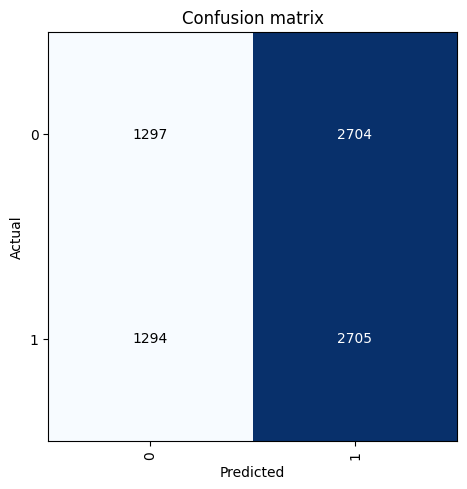

In [122]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [123]:
batch = dls.one_batch()
num_samples = 95

In [124]:
explainer = shap.GradientExplainer(
    learn.model.cpu(), torch.tensor(batch[0][:num_samples]).cpu()
)

# calculate shapely values
shap_values, indices = explainer.shap_values(
    torch.tensor(batch[0][num_samples:]).cpu(),
    ranked_outputs=2
)
print(shap_values)

[array([[[ 0.0009,  0.0057,  0.0079, ..., -0.0045, -0.0049, -0.0018],
        [ 0.0002,  0.0019,  0.0038, ..., -0.0039, -0.0027, -0.0016]],

       [[ 0.0006,  0.0048,  0.0062, ..., -0.0036, -0.004 , -0.0013],
        [ 0.0001,  0.0011,  0.0027, ..., -0.0029, -0.0021, -0.0012]],

       [[ 0.    ,  0.0049,  0.006 , ..., -0.004 , -0.0042, -0.0015],
        [-0.0005,  0.0012,  0.003 , ..., -0.005 , -0.0037, -0.002 ]],

       ...,

       [[-0.0004, -0.0035, -0.0028, ...,  0.0024,  0.0015,  0.0006],
        [-0.0009, -0.0001, -0.0013, ..., -0.0021, -0.0015, -0.0014]],

       [[-0.0025, -0.0041, -0.0039, ...,  0.0031,  0.0005,  0.0004],
        [-0.0008, -0.0019, -0.0022, ...,  0.0059,  0.0018, -0.0005]],

       [[-0.0029, -0.004 , -0.0044, ...,  0.0028,  0.0006,  0.0008],
        [ 0.    , -0.0013, -0.0018, ...,  0.0065,  0.0028,  0.0003]]]), array([[[-0.0005,  0.0014,  0.0006, ..., -0.0044, -0.0024, -0.0003],
        [-0.0014, -0.0003,  0.    , ..., -0.0029, -0.0025, -0.0017]],

     

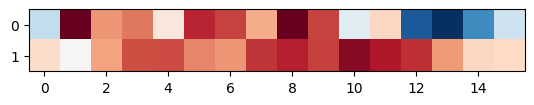

In [125]:
import matplotlib.pyplot as plt
import numpy as np
shap_out=shap_values[0]
plot_shap=shap_out[13,:,:]
plot_shap_scaled=np.log((plot_shap-plot_shap.min())/(plot_shap.max()-plot_shap.min()+1e-8))
plt.imshow(plot_shap, cmap='RdBu', interpolation='nearest')
plt.show()

In [126]:
import seaborn as sns

<Axes: >

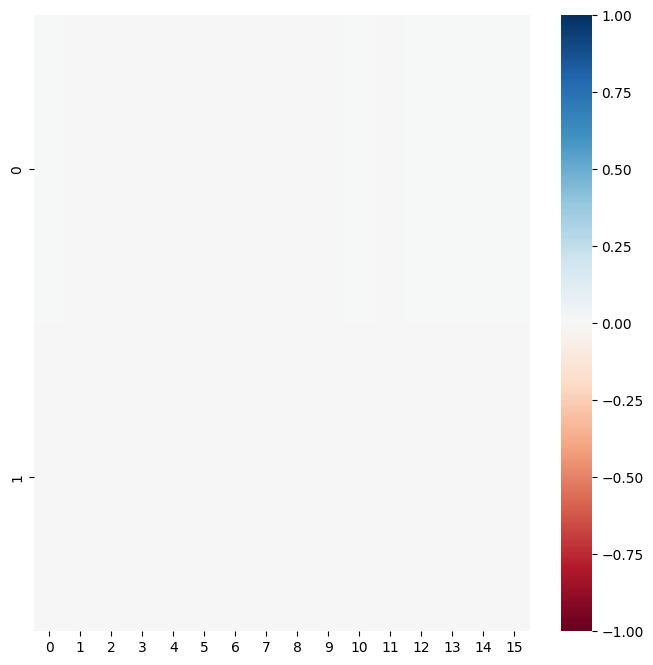

In [127]:
plt.figure(figsize=(8,8))
sns.heatmap(data=plot_shap, cmap='RdBu',vmin=-1,center=0,vmax=1)

<Axes: >

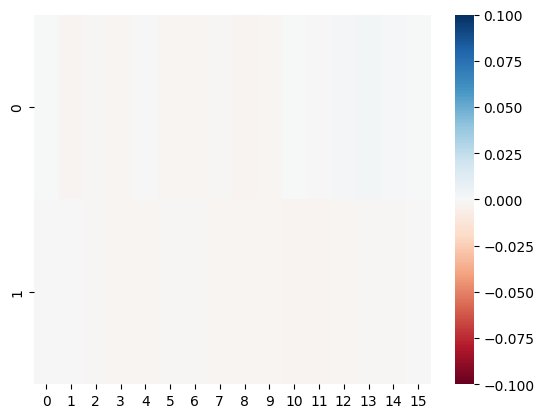

In [128]:
sns.heatmap(data=plot_shap, cmap='RdBu',vmin=-0.1,center=0,vmax=0.1)

In [129]:
neg_idx = np.where(np.array(batch[1][num_samples:].cpu())==0)
pos_idx = np.where(np.array(batch[1][num_samples:].cpu())==1)

In [130]:
little_check=batch[0][num_samples:]

pos_shap=shap_out[pos_idx,:,:]
neg_shap=shap_out[neg_idx,:,:]
pos_shap=pos_shap[0,:,:,:]
neg_shap=neg_shap[0,:,:,:]
pos_base=little_check[pos_idx,:,:]
neg_base=little_check[neg_idx,:,:]
pos_base=pos_base[0,:,:,:]
neg_base=neg_base[0,:,:,:]
pos_base=np.array(pos_base.cpu())
neg_base=np.array(neg_base.cpu())

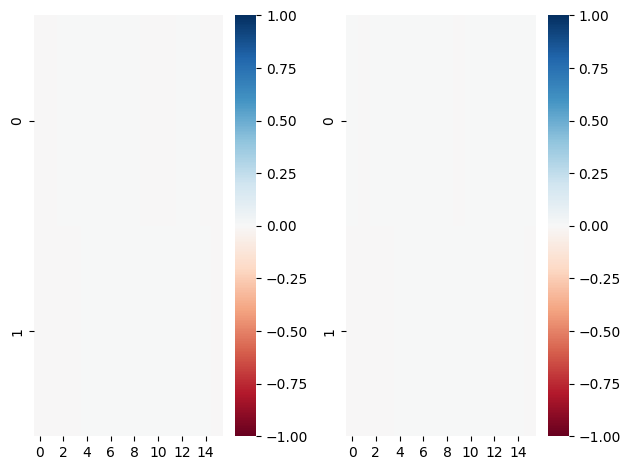

In [131]:
fig,axes = plt.subplots(1,2)
sns.heatmap(data=pos_shap.mean(0), cmap='RdBu',vmin=-1,center=0,vmax=1,ax=axes[0])
sns.heatmap(data=neg_shap.mean(0), cmap='RdBu',vmin=-1,center=0,vmax=1,ax=axes[1])
fig.tight_layout()

In [132]:
batch[1][num_samples:]

TensorCategory([0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
                0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1], device='cuda:1')

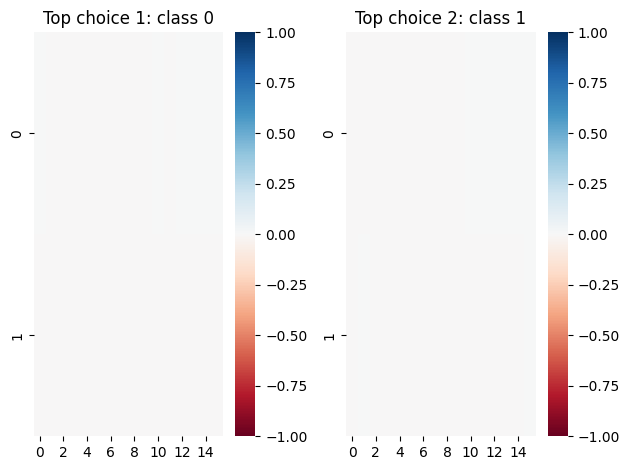

In [133]:
shap_num=13
fig,axes = plt.subplots(1,2)
sns.heatmap(data=shap_values[0][shap_num,:,:], cmap='RdBu',vmin=-1,center=0,vmax=1,ax=axes[0])
sns.heatmap(data=shap_values[1][shap_num,:,:], cmap='RdBu',vmin=-1,center=0,vmax=1,ax=axes[1])
axes[0].set_title(f'Top choice 1: class {indices[shap_num, 0]}')
axes[1].set_title(f'Top choice 2: class {indices[shap_num, 1]}')
fig.tight_layout()

In [134]:
shap_values[0][shap_num,:,:]

array([[ 0.0004, -0.0029, -0.0014, -0.0016, -0.0005, -0.0023, -0.002 ,
        -0.0012, -0.0029, -0.002 ,  0.0001, -0.0008,  0.002 ,  0.0025,
         0.0015,  0.0003],
       [-0.0007, -0.0002, -0.0013, -0.002 , -0.002 , -0.0015, -0.0014,
        -0.0021, -0.0023, -0.0021, -0.0027, -0.0024, -0.0022, -0.0014,
        -0.0008, -0.0008]])

In [135]:
shap_values[1][shap_num,:,:]

array([[-0.0005, -0.0054, -0.0057, -0.0049, -0.0047, -0.0046, -0.0011,
        -0.0013, -0.0018, -0.0005,  0.004 ,  0.0025,  0.0043,  0.0027,
         0.0034,  0.0016],
       [-0.0002,  0.0001, -0.001 , -0.0015, -0.0015, -0.0013, -0.0013,
        -0.0027, -0.0031, -0.0025, -0.0033, -0.0023, -0.002 , -0.002 ,
        -0.0005,  0.0007]])